<a href="https://colab.research.google.com/github/nahumsa/hackovid19/blob/master/Hackovid19_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segmentação para imagens de Ressonância

In [0]:
import numpy as np
import os
import nibabel as nib
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
 
# Set numpy to print only 2 decimal digits for neatness
np.set_printoptions(precision=2, suppress=True)

## Dados

Você deve baixar os dados [desse site](https://drive.google.com/file/d/1SJoMelgRqb0EuqlTuq6dxBWf2j9Kno8S/view) e dar upload no colab.

In [0]:
# !git clone https://github.com/nahumsa/hackovid19
# %cd hackovid19

drive.mount('/content/drive/')
%cd '/content/drive/My Drive/hackathon'
%ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
/content/drive/My Drive/hackathon
logs/                             tr_im.nii.gz    val_im.nii.gz
Test-Images-Clinical-Details.csv  tr_mask.nii.gz


In [0]:
img_train = os.path.join('tr_im.nii.gz')
img_train = nib.load(img_train)
#print(img_train.shape)

mask_train = os.path.join('tr_mask.nii.gz')
mask_train = nib.load(mask_train) 
#print(mask_train.shape)

img_val = os.path.join('val_im.nii.gz')
img_val = nib.load(img_val)
#print(img_val.shape)

Pré Processamento


In [0]:
def normalize_function(img, n_obj):

  imag = img.reshape(n_obj, 512, 512)
  maximo = np.max(img)
  minimo = np.min(img)
  delta = (maximo - minimo)  
  imag = (imag - minimo)/delta
  
  return imag

In [0]:
#Converte para np.array e faz reshape
img_train = img_train.get_fdata()
img_train = np.moveaxis(img_train,-1, 0)
#print(img_train.shape)
mask_train = mask_train.get_fdata()
mask_train = np.moveaxis(mask_train,-1, 0)
img_val = img_val.get_fdata()
img_val = np.moveaxis(img_val,-1, 0)

#Normaliza as entradas
img_train = normalize_function(img_train, 100)
img_val = normalize_function(img_val, 10)
mask_train = normalize_function(mask_train, 100)

#Adiciona uma dimensao representando o canal
img_train  = np.expand_dims(img_train, -1).astype('float32')
print(f"Shape do treino: {img_train.shape}")
img_val = np.expand_dims(img_val, -1).astype('float32')
print(f"Shape da validação: {img_val.shape}")
mask_train = np.expand_dims(mask_train, -1).astype('float32')
print(f"Shape da máscara: {img_train.shape}")

Shape do treino: (100, 512, 512, 1)
Shape da validação: (10, 512, 512, 1)
Shape da máscara: (100, 512, 512, 1)


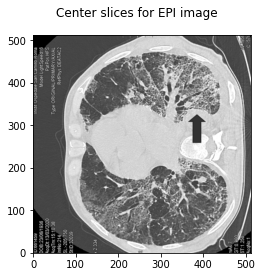

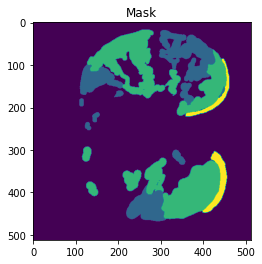

In [0]:
#Visualizacao das imagens

def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, 1)
   axes.imshow(slices, cmap="gray", origin="center")


slices = img_train.reshape(100,512,512,)
slices = slices[1,:,:]
show_slices(slices)
plt.suptitle("Center slices for EPI image") 
plt.show()
plt.imshow(mask_train[1,:,:,0]);
plt.title("Mask");

## Modelo


Para esse exemplo, utilizaremos o modelo UNET, pois é conhecido por ser bom para problemas de segmentação de imagens.

### Modelo 1

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D, UpSampling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

class Conv2d_block(tf.keras.layers.Layer):
  """Create a block of convolutional layers.
  """
  def __init__(self,               
               n_filters, 
               kernel_size=3,                
               **kwargs):
    
    super(Conv2d_block, self).__init__(**kwargs)
    self.conv1 = Conv2D(n_filters, kernel_size, 
                        activation = 'relu', padding = 'same', 
                        kernel_initializer = 'he_normal')
    self.conv2 = Conv2D(n_filters, kernel_size, 
                        activation = 'relu', padding = 'same', 
                        kernel_initializer = 'he_normal')

  def get_config(self):

    config = super(Conv2d_block, self).get_config().copy()
    config.update({
        'vocab_size': self.vocab_size,
        'num_layers': self.num_layers,
        'units': self.units,
        'd_model': self.d_model,
        'num_heads': self.num_heads,
        'dropout': self.dropout,
    })
    return config

  def call(self, inputs):
    x = self.conv1(inputs)
    return self.conv2(x)


#### Losses

In [0]:
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(y_true * y_pred, axis=[1,2,3])
  union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
  dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
  return dice

def dice_loss(y_true, y_pred):
  return 1-dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    The jaccard distance loss is usefull for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.
    
    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    
    @url: https://gist.github.com/wassname/f1452b748efcbeb4cb9b1d059dce6f96
    @author: wassname
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [0]:

def unet(pretrained_weights = None, input_size=(256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2d_block(64)(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1)

    conv2 = Conv2d_block(128)(pool1)    
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2d_block(256)(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2d_block(512)(pool3)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2d_block(1024)(pool4)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2d_block(512)(merge6)    

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    merge7 = Dropout(0.5)(merge7)
    conv7 = Conv2d_block(256)(merge7)    

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    merge8 = Dropout(0.5)(merge8)
    conv8 = Conv2d_block(128)(merge8)    

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2d_block(64)(merge9)    
    merge9 = Dropout(0.5)(merge9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = [inputs], outputs = [conv10])

    model.compile(optimizer = Adam(lr = 1e-4), loss = dice_loss, metrics = ['accuracy'])

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

#Definindo o modelo
model = unet(input_size=(512, 512, 1))

In [0]:
#modelo com predicao
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_train, mask_train, 
                                                    test_size=0.1, random_state=42)

BATCH = 8
EPOCAS = 100

history = model.fit(X_train, 
          y_train, 
          batch_size=BATCH, 
          validation_data=(X_test, y_test),          
          epochs=EPOCAS)

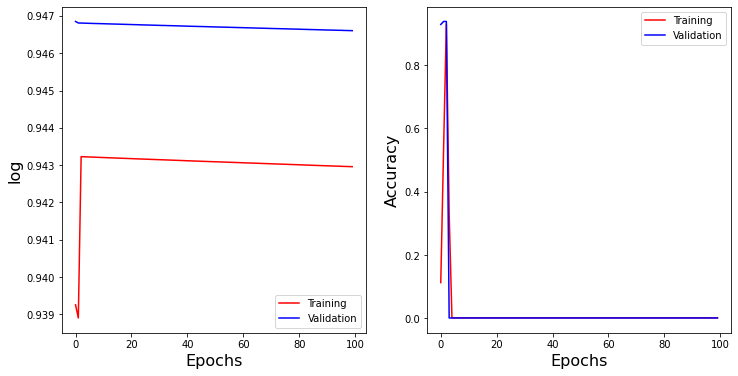

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

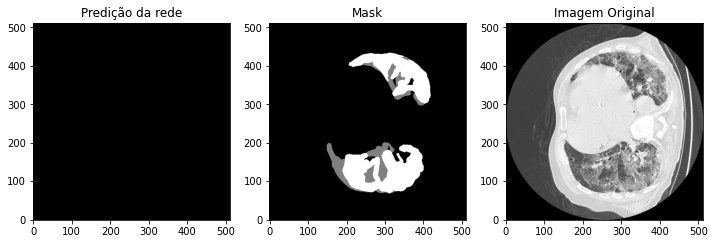

In [0]:
#plot dados 

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

val = model.predict(img_train[:10])
slices = val.reshape(10, 512,512,)
slices = slices[0, :,:]
ax1.imshow(slices, cmap='gray', origin='center')
ax1.set_title('Predição da rede')
ax2.imshow(mask_train[0,:,:,0], cmap="gray", origin="center")
ax2.set_title('Mask')
ax3.imshow(img_train[0,:,:,0], cmap="gray", origin="center")
ax3.set_title('Imagem Original')
plt.show()

### Modelo 2

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x
    
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
  # Contracting Path
  c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
  p1 = MaxPooling2D((2, 2))(c1)
  p1 = Dropout(dropout)(p1)

  c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
  p2 = MaxPooling2D((2, 2))(c2)
  p2 = Dropout(dropout)(p2)

  c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
  p3 = MaxPooling2D((2, 2))(c3)
  p3 = Dropout(dropout)(p3)

  c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
  p4 = MaxPooling2D((2, 2))(c4)
  p4 = Dropout(dropout)(p4)

  c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

  # Expansive Path
  u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
  u6 = concatenate([u6, c4])
  u6 = Dropout(dropout)(u6)
  c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

  u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
  u7 = concatenate([u7, c3])
  u7 = Dropout(dropout)(u7)
  c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

  u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
  u8 = concatenate([u8, c2])
  u8 = Dropout(dropout)(u8)
  c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

  u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
  u9 = concatenate([u9, c1])
  u9 = Dropout(dropout)(u9)
  c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

  outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
  model = Model(inputs=[input_img], outputs=[outputs])
  return model

In [0]:
input_img = Input((512, 512, 1), name='img')
model = get_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_loss, metrics=["accuracy"])
#model.summary()

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_train, mask_train, 
                                                    test_size=0.1, random_state=42)

BATCH = 8
EPOCAS = 100

history = model.fit(X_train, 
          y_train, 
          batch_size=8, 
          validation_data=(X_test, y_test),          
          epochs=10)

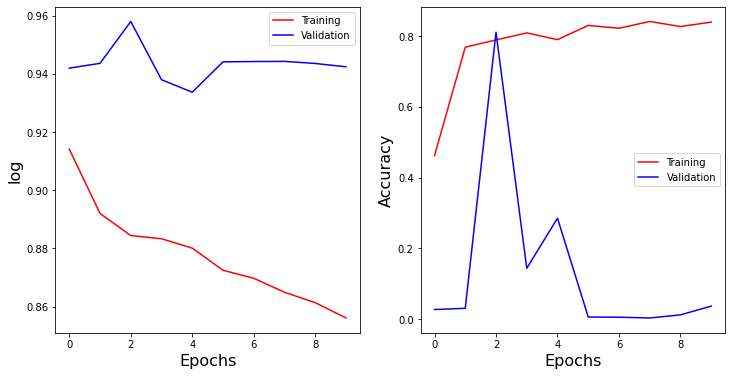

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(len(loss))

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(epochs, loss, 'r', label='Training')
ax1.plot(epochs, val_loss, 'b', label='Validation')
ax1.set_xlabel('Epochs', size=16)
ax1.set_ylabel('Loss', size=16)
ax1.set_ylabel('log')
ax1.legend()

ax2.plot(epochs, accuracy, 'r', label='Training')
ax2.plot(epochs, val_accuracy, 'b', label='Validation')
ax2.set_xlabel('Epochs', size=16)
ax2.set_ylabel('Accuracy', size=16)
ax2.legend()
plt.show()

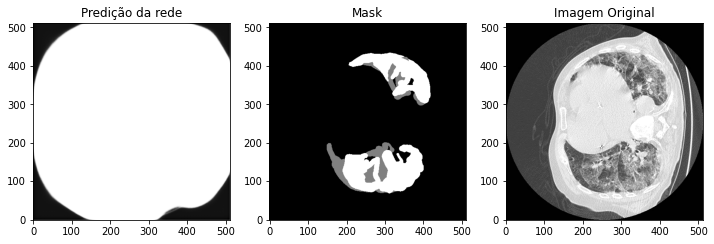

In [0]:
#plot dados 

fig = plt.figure(figsize=(12,6))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

val = model.predict(img_train[:10])
slices = val.reshape(10, 512,512,)
slices = slices[0, :,:]
ax1.imshow(slices, cmap='gray', origin='center')
ax1.set_title('Predição da rede')
ax2.imshow(mask_train[0,:,:,0], cmap="gray", origin="center")
ax2.set_title('Mask')
ax3.imshow(img_train[0,:,:,0], cmap="gray", origin="center")
ax3.set_title('Imagem Original')
plt.show()